# House price prediction problem

Predicting US house price data for introductory Kaggle competition: **House Prices - Advanced Regression Techniques"

### Load packages

In [1]:
# Base packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# SKlearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
random_seed = 10

# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.regularizers import L2
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau

C:\Users\LG Gram\AppData\Local\Temp\ipykernel_20200\4058632844.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## EDA and data preprocessing

### Import data

In [68]:
# Load training and test data
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

# Group data into a combined list
combine = [train_df, test_df]

### Examine data

In [69]:
print(train_df.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [70]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# EDA and Feature engineering

### MSSubClass // MSZoning

Class of type of building. There are 15 classes referring to the different type of building (e.g. # stories, age, finished). For MSZoning there are 5 classes.

Some categories differ only by date of build, which in the model will be covered by the `YearBuilt` column. Therefore, we can merge these categories. Other category merges will be made where the description is reasonably similar, distribution of house prices is similar and the counts are relatively low. All MSZoning classes are maintained.

In [71]:
# Create new column for processed class
for df in combine:
    df['ProcessedClass']=df['MSSubClass'].copy().astype(str) # Create new processed class column
    df.loc[df['MSSubClass'].isin([20,30,40,45,50,120]),'ProcessedClass'] = '1 Story' # Combine all one story categories into one
    df.loc[df['MSSubClass'].isin([60,70,75,160]),'ProcessedClass'] = '2 Story' # Combine all two story categories into one
    df.loc[df['MSSubClass'].isin([80,85]),'ProcessedClass'] = 'Split' # Combine all split categories into one
    df.loc[df['MSSubClass'].isin([90]),'ProcessedClass'] = 'Duplex' # Duplex
    df.loc[df['MSSubClass'].isin([180]),'ProcessedClass'] = 'Multilevel' # Multilevel
    df.loc[df['MSSubClass'].isin([190]),'ProcessedClass'] = 'Conversion' # 2 family conversions

    # Create OH Category for PUD
    df['IsPUD'] = df['MSSubClass'].isin([120,150,160,180])*1

    # Drop original column
    df.drop(['MSSubClass'],axis=1,inplace=True)

### Alley/Street access

There are so few with gravel street access that we can just drop the Street category (6). 

For alley, a large share do not have an alley. We create two features - one to say if an alley is present or not, and a second setting if it is paved.

In [72]:
# Create features for having an alley, and alley style
for df in combine:
    df['HasAlley'] = df["Alley"].notna()
    df['PavedAlley'] = df['Alley'].map(lambda x: 1 if x=='Pave'else 0)

    df.drop(['Alley','Street'],axis=1,inplace=True)

### Utilities

Utilities category can be dropped as almost every single one follows into category `AllPub`

In [73]:
for df in combine:
    df.drop(['Utilities'],axis=1,inplace=True) # Drop utilities category

### Neighbourhood

Histogram demonstratest high variance in sales price by neighbourhood, therefore all neighbourhood categories will be kept

### Conditions

For conditions, we will create the following features from the Condition1 and Condition2 columns, and then drop the original Condition1 and Condition2:
- Near railroad
- Near arterial road
- Near feeder street
- Near positive feature

In [74]:
# For
for df in combine:
    merged_condition = (df['Condition1'] + train_df['Condition2']).astype(str)
    df['NrRail'] = (1*merged_condition.apply(lambda x: re.search('RR',x) is not None)).astype(int)
    df['NrArtery'] = (1*merged_condition.apply(lambda x: re.search('Artery',x) is not None)).astype(int)
    df['NrFeedr'] = (1*merged_condition.apply(lambda x: re.search('Feedr',x) is not None)).astype(int)
    df['NrPos'] = (1*merged_condition.apply(lambda x: re.search('Pos',x) is not None)).astype(int)

print(train_df['Condition1'].value_counts())


Condition1
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: count, dtype: int64


In [75]:
for df in combine:
    df.drop(['Condition1','Condition2'],axis=1,inplace=True)

### Building type // HouseStyle
Building type keep as is, House Style is dropped as we cover it already earlier on

In [76]:
for df in combine:
    df.drop(['HouseStyle'],axis=1,inplace=True)

## Year Built // Remodel year

Signs of an exponential trend on YearBuilt, therefore adding an exponential term on its normalized value which improves R2 by 7%

Remodelled: Create features for: 
- Remodelled in last 10 years
- Remodelled in last 20 years
- Remodelled ever

In [77]:
for df in combine:
    df['Remodelled'] = 1*(df['YearBuilt'] != df['YearRemodAdd'])
    df['Remodelled_2000'] = (df['Remodelled'] * (df['YearRemodAdd']>=2000)).astype(int)
    df['Remodelled_1990'] = (df['Remodelled'] * (df['YearRemodAdd']>=1990) * (df['YearRemodAdd']<2000)).astype(int)

### Roof Style // Roof Material

For roof material, group the very rare categories into `CompShg`

In [78]:
for df in combine:
    df['RoofMatl'] = df['RoofMatl'].map(lambda x: x if x in ['Tar&Grv','WdShake','WdShngl'] else 'CompShg')

### Exterior

Reduce dimensionality by merging any categories with <10 counts into the mode

In [79]:
# Function to remove categories with values less than a threshold and reassign to the mode
def remove_low_counts(data, threshold):
    val_counts = data.value_counts()
    return data.map(lambda x: val_counts.index[0] if pd.isna(x) or val_counts[x]<threshold else x)

In [80]:
for df in combine:    
    df['Exterior1st'] = remove_low_counts(df['Exterior1st'],10)
    df['Exterior2nd'] = remove_low_counts(df['Exterior2nd'],10)

### Masonry

Make masonry a binary of Brick:Stone due to low counts on Brick common. Keep masonry area as a numerical to be normalized

In [81]:
for df in combine:
    df['MasonryStone'] = (1 * (df['MasVnrType']=='Stone')).astype(int)
    df.drop(['MasVnrType'],axis=1,inplace=True)

### Quality and condition

Quality and condition categories will be converted into a numerical representation since they are ordinal

In [82]:
# Create dictionary of quality class translations
qual_classes = ["NA","Po","Fa","TA","Gd","Ex"]
qual_dict = {}
for k,class_label in enumerate(qual_classes):
    qual_dict[class_label] = k

Apply this translation to quality-based categories

In [83]:
qual_categories = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','HeatingQC','FireplaceQu',
                   'GarageQual','GarageCond','PoolQC','KitchenQual']

for df in combine:
    for col in qual_categories:
        if df[col].dtype == object:
            df.loc[df[col].isna(), col] = 0
            df[col] = df[col].map(lambda x: qual_dict[x] if x in qual_dict else 0).astype(int)

In general, based on below scatter plots we can keep all condition graphs as they are. Exceptions are:
- BSMT exposure can be removed as all houses with basements have the same exposure
- There are only 5 houses with pools, so we just make this a binary to have a pool or not


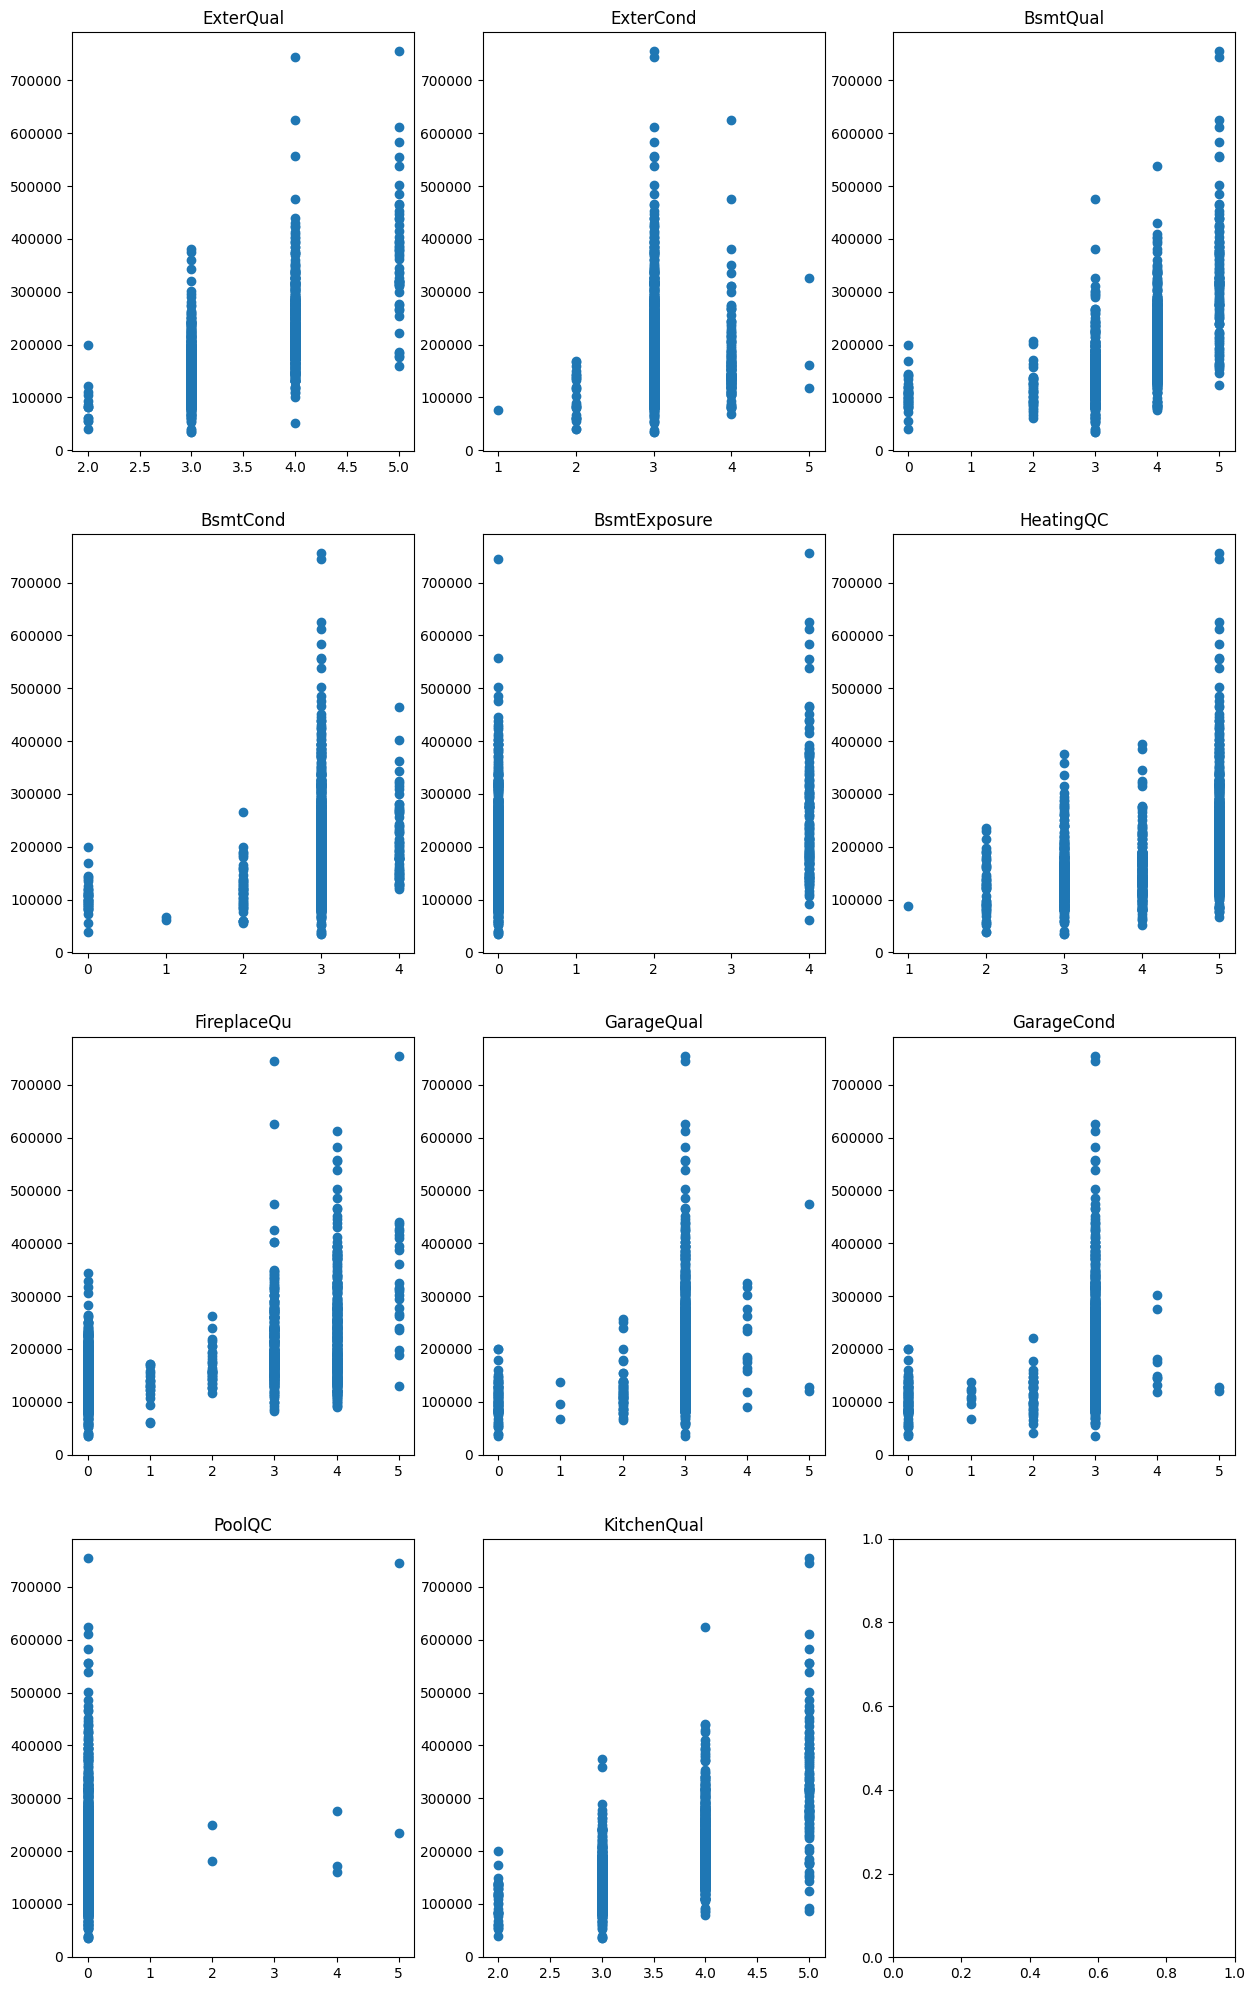

In [84]:
figure, ax_list = plt.subplots(4,3,figsize=(15,25))
counter = 0

# Create subplots for all quality variables
for k in range(ax_list.shape[0]):
    for j in range(ax_list.shape[1]):
        ax_list[k,j].scatter(train_df[qual_categories[counter]],train_df['SalePrice'])
        ax_list[k,j].title.set_text(qual_categories[counter])
        counter+=1
        if counter == len(qual_categories):
            break

In [85]:
for df in combine:
    df['PoolQC'] = (1*(df['PoolQC']>0)).astype(int)
    df.drop(['BsmtExposure'],axis=1,inplace=True)

### Basement

Turn finish type into a numerical range similar to quality scoring

In [86]:
# Create basement class dictionary
qual_classes = ['Unf', 'LwQ','Rec','BLQ','ALQ','GLQ']
qual_dict = {}
for k,qual_class in enumerate(qual_classes):
    qual_dict[qual_class] = k

for df in combine:
    df['BsmtClass'] = (df['BsmtFinType1'].map(lambda x: qual_dict[x] if x in qual_dict else 0)).astype(int)

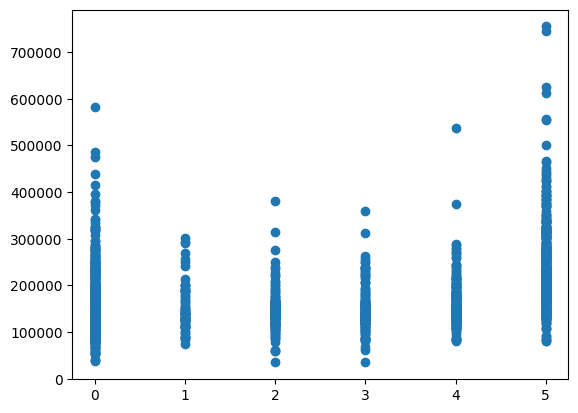

In [87]:
plt.scatter(train_df['BsmtClass'],train_df['SalePrice'])

### Heating, AC Electrics

We can drop heating as almost everything is Gas.
AC we turn into a categorical variable.

In [88]:
for df in combine:
    df.drop(['Heating'],axis=1,inplace=True)
    df['CentralAir']=(1*df['CentralAir']=="Y").astype(int)
    df.drop(['Electrical'],axis=1,inplace=True)

## Square footage categories

Examine with scatterplots significance of each square footage. Feature engineering proposed:
- Add category for total outdoor square footage and overall outdoor + indoor square foot
- Remove LowQualFinSF due to low non-zero count and insignificant trend
- Remove PoolArea due to very low count

In [89]:
# Add category for total outdoor sqft and total outdoor + indoor sqft
for df in combine:
    df['OutdoorSF'] = df[['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']].sum(axis=1)
    df['OverallSF'] = df[['OutdoorSF','BsmtFinSF1','GrLivArea']].sum(axis=1)

In [90]:
# Set square footage categories
sqft_categories = ['1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF',
                   'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea', 'BsmtFinSF1','OutdoorSF','OverallSF']

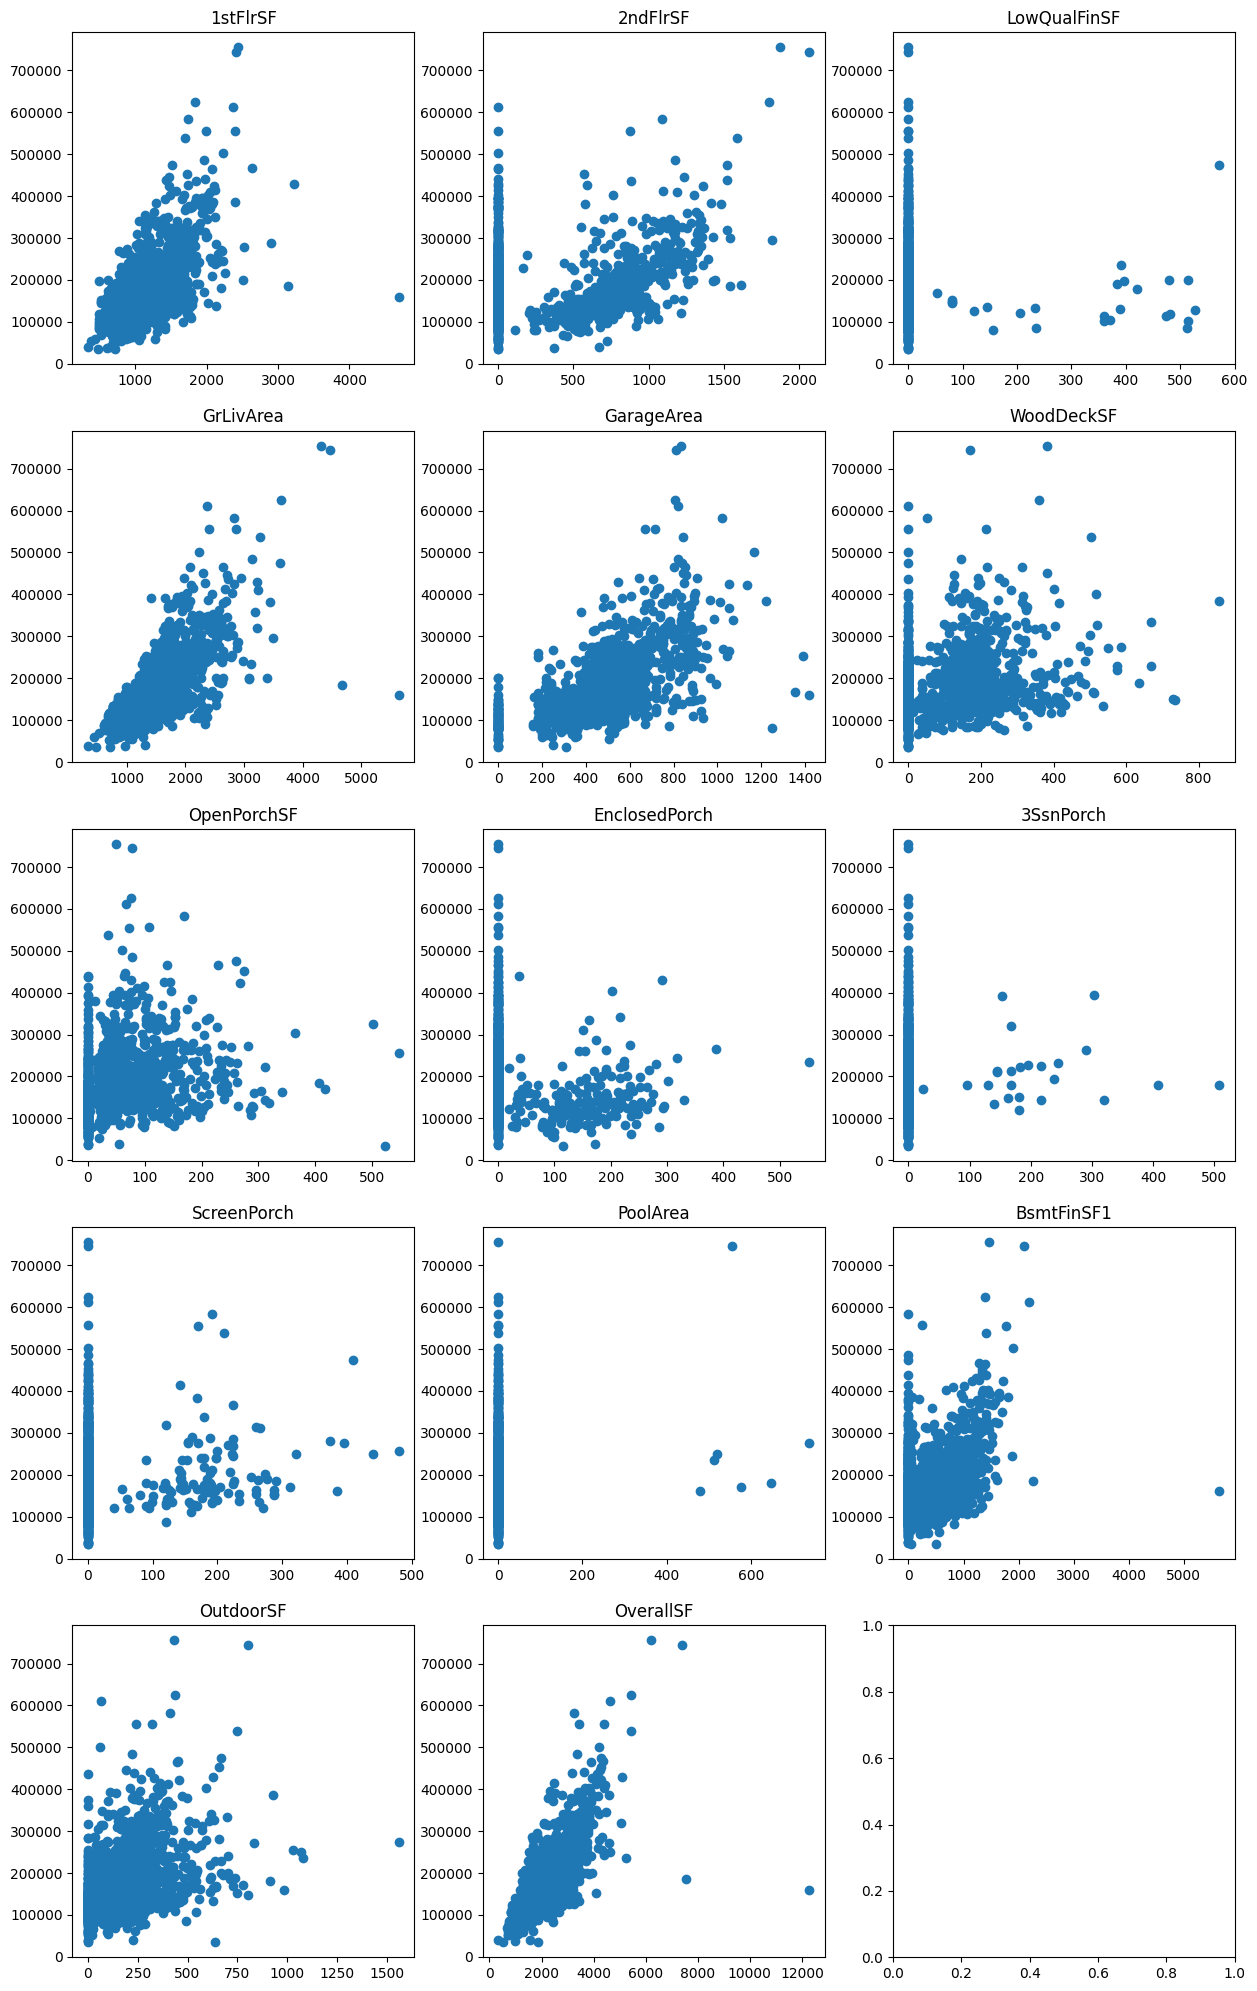

In [91]:
figure, ax_list = plt.subplots(5,3,figsize=(15,25))
counter = 0

# Create subplots for all quality variables
for k in range(ax_list.shape[0]):
    for j in range(ax_list.shape[1]):
        ax_list[k,j].scatter(train_df[sqft_categories[counter]],train_df['SalePrice'])
        ax_list[k,j].title.set_text(sqft_categories[counter])
        counter+=1
        if counter == len(sqft_categories):
            break

In [92]:
for df in combine:
    df.drop(['LowQualFinSF','PoolArea'],axis=1,inplace=True)

## Count categories

Evaluate significane of all room count categories. Suggested actions are:
- Create AllBath category including full and half bathrooms (0.5 weighting for half) and remove each underlying category (apart from FullBath)
- Remove kitchen category as almost all have only 1 kitchen

In [93]:
# Create all bath categories as 1*Full Bathroom +0.5*half bathroom
for df in combine:
    df['AllBath'] = df['FullBath']+df['BsmtFullBath']+df['HalfBath'].map(lambda x:0.5*x) + df['BsmtFullBath'].map(lambda x: 0.5*x)

In [94]:
count_categories = ['BsmtFullBath','FullBath','HalfBath','AllBath','BedroomAbvGr','KitchenAbvGr',
                   'TotRmsAbvGrd','Fireplaces','GarageCars']

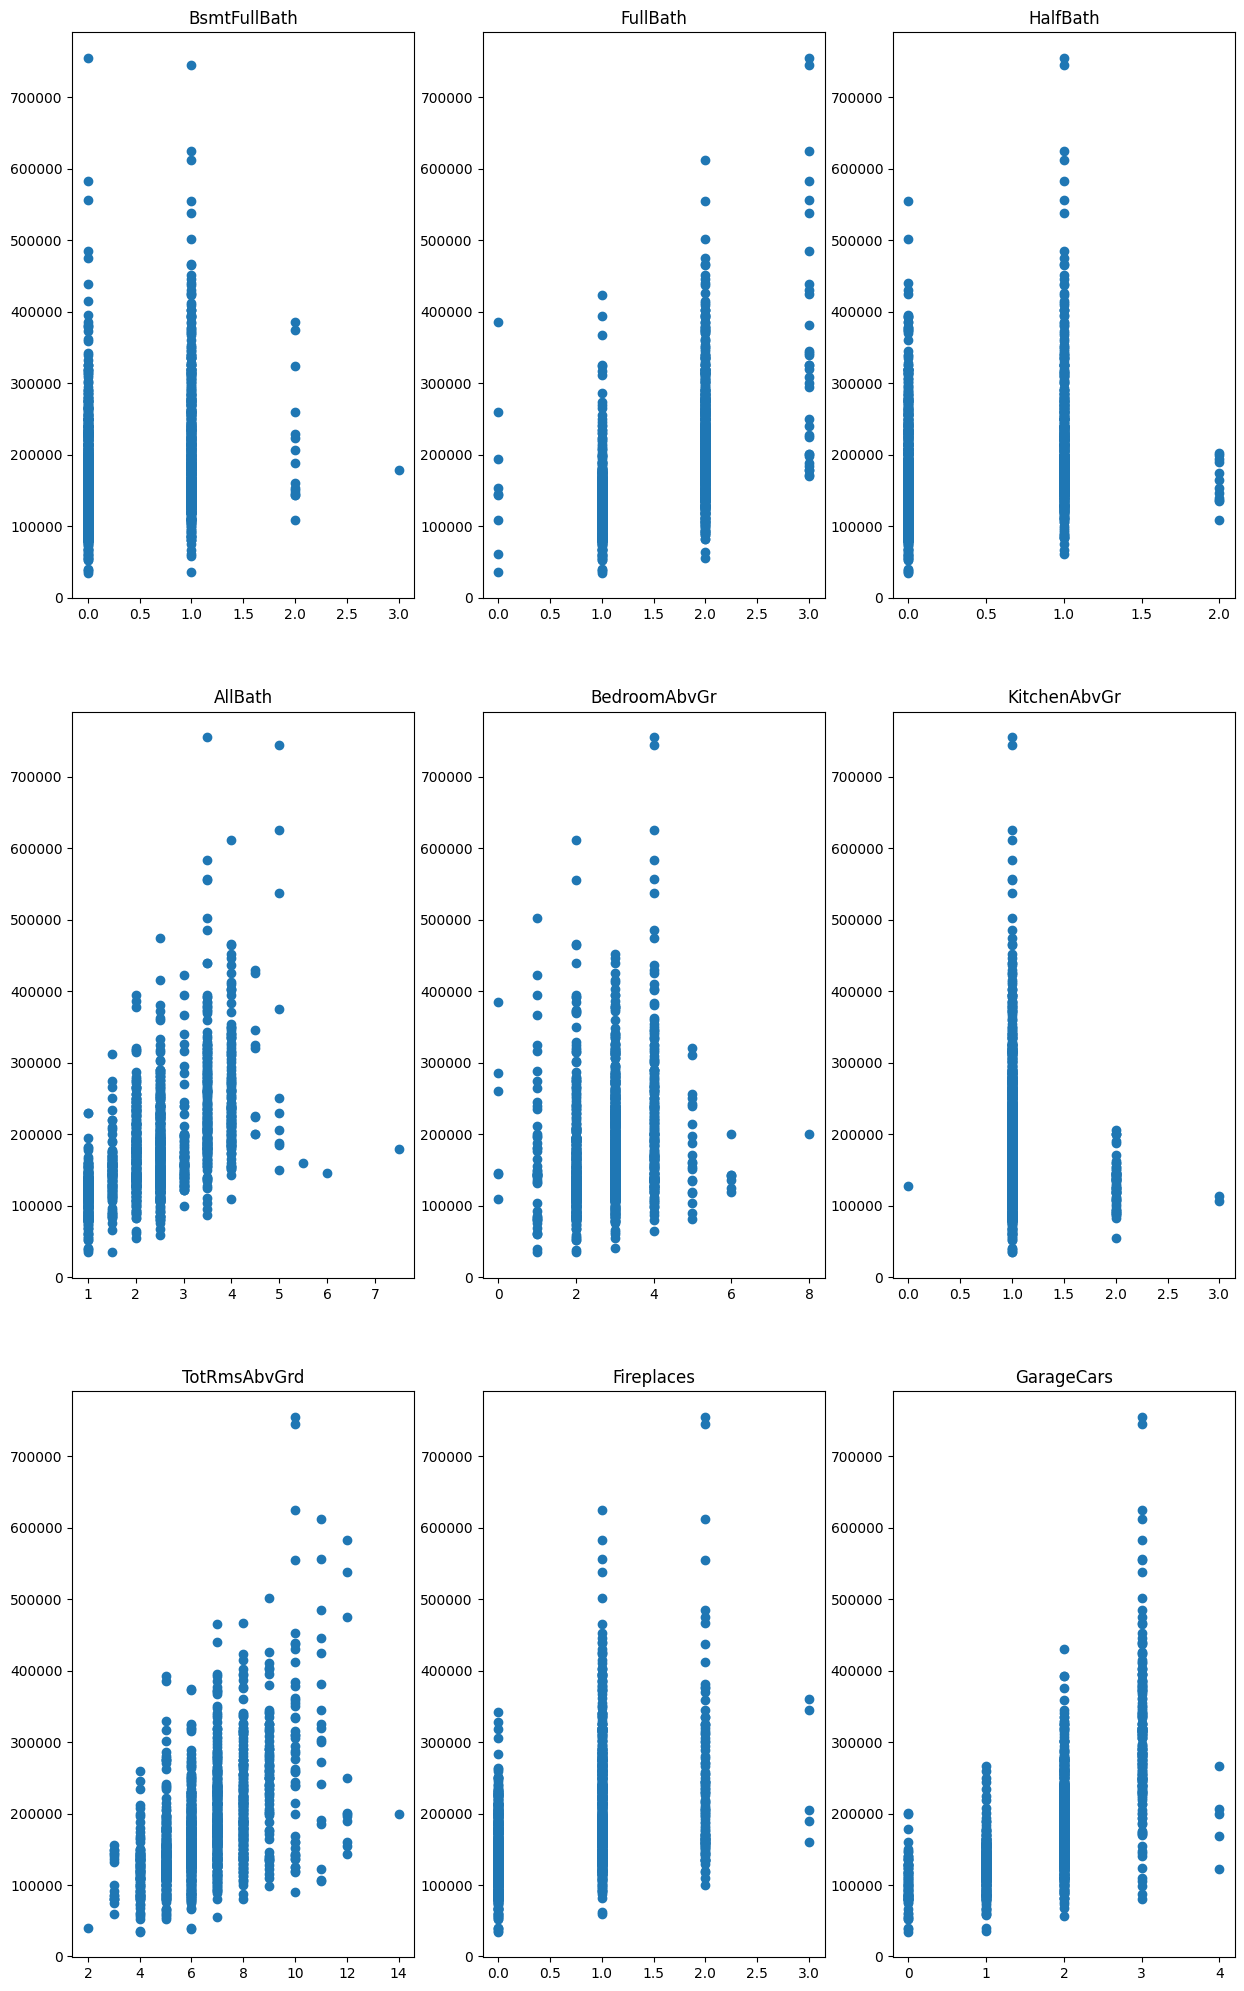

In [95]:
figure, ax_list = plt.subplots(3,3,figsize=(15,25))
counter = 0

# Create subplots for all quality variables
for k in range(ax_list.shape[0]):
    for j in range(ax_list.shape[1]):
        ax_list[k,j].scatter(train_df[count_categories[counter]],train_df['SalePrice'])
        ax_list[k,j].title.set_text(count_categories[counter])
        counter+=1
        if counter == len(count_categories):
            break

In [96]:
for df in combine:
    df.drop(['BsmtFullBath','HalfBath','KitchenAbvGr','BsmtHalfBath'],axis=1,inplace=True)

### Functionality

Use integer scale point conversion, and drop class labels

In [97]:
# Create basement class dictionary
qual_classes = ['Sal', 'Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']
qual_dict = {q:k for k,q in enumerate(qual_classes)}

for df in combine:
    df['FunctionClass'] = (df['Functional'].map(lambda x: qual_dict[x] if x in qual_dict else 0)).astype(int)

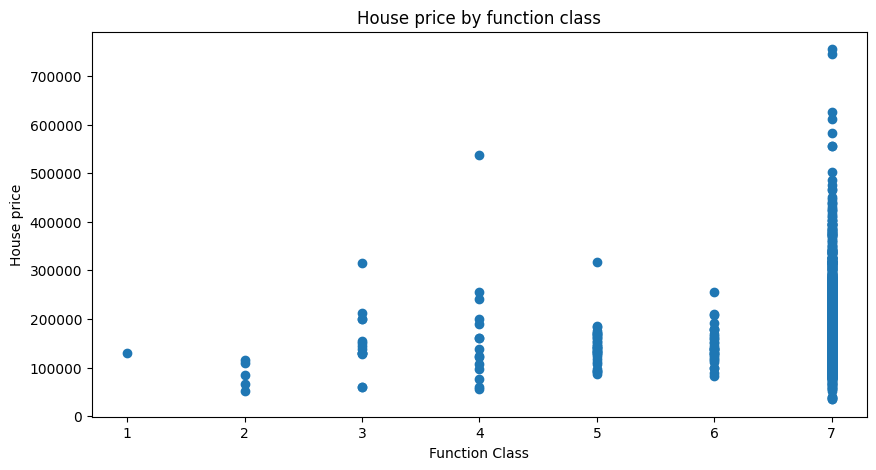

In [98]:
figure = plt.figure(figsize=(10,5))
plt.scatter(train_df['FunctionClass'],train_df['SalePrice'])
plt.ylabel('House price')
plt.xlabel('Function Class')
plt.title('House price by function class')
plt.show()

In [99]:
for df in combine:
    df.drop('Functional',axis=1,inplace=True)

### Date sold

Keep years as annual numbers. Map months to quarters.

In [100]:
for df in combine:
    df['QuSold'] = df['MoSold'].map(lambda x: "M" + str(np.ceil(x/3)))

## Sale type and condition

For sale type and condition, remove low count categories

In [101]:
for df in combine:
    df['SaleType'] = remove_low_counts(df['SaleType'],5)
    df['SaleCondition'] = remove_low_counts(df['SaleCondition'],5)

In [102]:
for df in combine:
    df['SaleCondition'] = df['SaleCondition'].map(lambda x: 'Other' if x not in ['Normal', 'Partial'] else x)

## Data cleaning 

### Label scaling

Take log of y labels and remove IDs

In [103]:
# Take log of sale price and remove from train df
y_all = np.log(train_df['SalePrice'])
train_df.drop('SalePrice',axis=1,inplace=True)

# Drop IDs
for df in combine:
    df.drop('Id',axis=1,inplace=True)


### Remove NAN values

Check for NAN values in train and test data

In [104]:
nan_columns = train_df.columns[pd.concat((train_df,test_df)).isna().any()]

nan_df = pd.concat((train_df[nan_columns].isna().sum(),test_df[nan_columns].isna().sum()),axis=1)
nan_df.columns = ["Train", "Test"]

print("NaN count:")
print(nan_df)

NaN count:
              Train  Test
MSZoning          0     4
LotFrontage     259   227
MasVnrArea        8    15
BsmtFinType1     37    42
BsmtFinSF1        0     1
BsmtFinType2     38    42
BsmtFinSF2        0     1
BsmtUnfSF         0     1
TotalBsmtSF       0     1
GarageType       81    76
GarageYrBlt      81    78
GarageFinish     81    78
GarageCars        0     1
GarageArea        0     1
Fence          1179  1169
MiscFeature    1406  1408
AllBath           0     2


Analyze nature of nan columns. Proposed approach is: 
- Set NaN values to the minimum values of numerical columns, since nan values are typically due to not having the given feature
- Set NaN values of object columns to the most frequent item unless there are large number of NaN (greater than half training set), in which case set to "Unknown"

In [105]:
# Find columns for each different dtype
object_columns = train_df.select_dtypes(include=['object']).columns

# For numerical columns, do not include ID to be normalized
numerical_columns = train_df.select_dtypes(include=['int','float']).columns

Remove NAN according to:
- In columns with over half values as NaN, assign NaN values to their own `Unknown` category
- In remaining object columns with NaN, assign NaN values to the mode
- In numerical columns, assign NaN values to the minimum

In [106]:
# First handle high nan columns in object columns
for col in object_columns:
    if train_df[col].isna().sum() > (train_df.shape[0]/2):
        train_df[col] = train_df[col].fillna(value="Unkown")
        test_df[col] = test_df[col].fillna(value="Unkown")

# THen handle remaining cases
for df in combine:
    df[object_columns] = df[object_columns].fillna(value=train_df[object_columns].mode().iloc[0])
    df[numerical_columns] = df[numerical_columns].fillna(value=train_df[numerical_columns].min())

Confirm all NaN removed

In [107]:
print("Total nan in training set: %i" % (train_df.isna().sum().sum()))
print("Total nan in test set: %i" % (test_df.isna().sum().sum()))

Total nan in training set: 0
Total nan in test set: 0


### Standard scalar transformations

For numerical (non-class based) columns, apply standard scaler transformations. Criteria to apply scalar transformation will be if max value is greater than 10.

In [108]:
scale_columns = numerical_columns[train_df[numerical_columns].max()>10]

# Scale all numerical categories
numerical_columns = train_df.select_dtypes(include=['int','float']).columns
scale_columns = numerical_columns[train_df[numerical_columns].max()>6]
scale_fit = StandardScaler().fit(train_df[scale_columns])

for df in combine:
    df[scale_columns] = scale_fit.transform(df[scale_columns])

### One hot encoding

One hot encode train and test dataset according to train dataset categories

In [109]:
# Initialize and fit OH encoder on categorical features
enc = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
cat_features = train_df.select_dtypes(include=['object']).columns
enc.fit(train_df[cat_features])

# Function to OH encode only categorical features using encoder
def oh_encode(enc, df):
    encoded_df = pd.DataFrame(enc.transform(df[cat_features]),columns=enc.get_feature_names_out())
    df = pd.concat((df,encoded_df),axis=1)
    df.drop(cat_features,axis=1,inplace=True)
    return df

# Update train and test df with OH encoding
train_df = oh_encode(enc,train_df)
test_df = oh_encode(enc,test_df)

In [110]:
# Check resulting shape
print(train_df.shape)
print(test_df.shape)

(1460, 197)
(1459, 197)


## Model

#### Make predictions using a simple MLP in Keras

Prepare train-test split

In [111]:
x_train, x_dev, y_train, y_dev = train_test_split(train_df,y_all,test_size=0.2,random_state=random_seed)
x_test = test_df

Prepare accuracy callback function

In [112]:
def check_accuracy(model,train,dev):
    train_preds = model.predict(train,verbose=0).flatten()
    dev_preds = model.predict(dev,verbose=0).flatten()

    print("R2 on training data: {:.1%}\nR2 on development data: {:.1%}".format(r2_score(y_train,train_preds), r2_score(y_dev,dev_preds)))
    print("RMSE on training data: {:.3}\nRMSE on development data: {:.3}".format(root_mean_squared_error(y_train,train_preds),root_mean_squared_error(y_dev,dev_preds)))

### Neural Network architecture

Neural network prediction methods using Keras. Given the prediction problem is relatively simple, in general a NN provides limited improvement over a simple linear regression.

However, we add an initial one-one connected weight layer to weight each input, and then apply a sigmoid activation function. This allows the model to 'select' which features to give more importance to, and improves its prediction power. Adding additional hidden layers in the core of the network was not found to increase performance, and risked overfitting.

One-one connected layer is built as a custom layer

In [113]:
# Weighted Input Layer

class WeightedLayer(tf.keras.layers.Layer):

    def __init__(self,activation=None,kernel_regularizer=None,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.kernel_regularizer = kernel_regularizer if kernel_regularizer is not None else None

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape=(int(input_shape[-1]),))

    def call(self,inputs):
        weighted_inputs = tf.multiply(inputs, self.kernel)
        if self.activation is not None:
            return self.activation(weighted_inputs)
        else:
            return weighted_inputs

    def get_config(self):
        config = super().get_config()
        config.update({
            'activation': tf.keras.activations.serialize(self.activation),
            'kernel_regularizer': tf.keras.regularizers.serialize(self.kernel_regularizer),
        })
        return config

Assemble model

In [114]:
# Assemble model using functional API
input = Input(shape=(x_train.shape[1],))
x = WeightedLayer(input_shape=(x_train.shape[1],),name='w_layer',activation='sigmoid')(input)
output = Dense(1,activation='linear')(x)

# Assemble and summarize model
nn_model = Model(inputs=input,outputs=output,name="functional_model")
nn_model.summary()

Model: "functional_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 197)]             0         
                                                                 
 w_layer (WeightedLayer)     (None, 197)               197       
                                                                 
 dense_2 (Dense)             (None, 1)                 198       
                                                                 
Total params: 395 (1.54 KB)
Trainable params: 395 (1.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [115]:
# RMSE loss
def rmse_keras(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Learning rate scheduler to gradually reduce 
scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.7,patience=10,verbose=1,min_lr=0.00001)

In [116]:
# Convert input data into tensor compatible format
x_train_tf = np.asarray(x_train).astype('float32')
x_dev_tf = np.asarray(x_dev).astype('float32')
x_test_tf = np.asarray(x_test).astype('float32')

In [117]:
# Compile and fit the model
nn_model.compile(optimizer=Adam(0.01),loss=rmse_keras,metrics=[rmse_keras])
nn_model.fit(x_train_tf,y_train,batch_size=32,epochs=200,verbose=1,validation_data=(x_dev_tf,y_dev),callbacks=[scheduler])

Epoch 1/200
37/37 [==============================] - ETA: 0s - loss: 3.1928 - rmse_keras: 3.1572 

37/37 [==============================] - 2s 16ms/step - loss: 3.1928 - rmse_keras: 3.1572 - val_loss: 0.7725 - val_rmse_keras: 0.7643 - lr: 0.0100
Epoch 2/200
37/37 [==============================] - 0s 5ms/step - loss: 0.3484 - rmse_keras: 0.3463 - val_loss: 0.2048 - val_rmse_keras: 0.2078 - lr: 0.0100
Epoch 3/200
37/37 [==============================] - 0s 5ms/step - loss: 0.1771 - rmse_keras: 0.1772 - val_loss: 0.1495 - val_rmse_keras: 0.1486 - lr: 0.0100
Epoch 4/200
37/37 [==============================] - 0s 5ms/step - loss: 0.1727 - rmse_keras: 0.1724 - val_loss: 0.1328 - val_rmse_keras: 0.1321 - lr: 0.0100
Epoch 5/200
37/37 [==============================] - 0s 5ms/step - loss: 0.1382 - rmse_keras: 0.1381 - val_loss: 0.1281 - val_rmse_keras: 0.1271 - lr: 0.0100
Epoch 6/200
37/37 [==============================] - 0s 5ms/step - loss: 0.1280 - rmse_keras: 0.1278 - val_loss: 0.1583 - val_rmse_keras: 0.1591 - lr: 0.0100
Epoch 7/200
37/37 [==============================] - 0s 5ms/ste

In [118]:
check_accuracy(nn_model,x_train_tf,x_dev_tf)

R2 on training data: 92.5%
R2 on development data: 91.4%
RMSE on training data: 0.108
RMSE on development data: 0.123


## Make and submit predictions

Use MLP to make test predictions

In [119]:
# Use nn model to make test predictions
preds_nn = np.exp(nn_model.predict(x_test_tf).flatten())

46/46 [==============================] - 0s 2ms/step


Prepare output dataframe

In [120]:
# Save outputs
output = pd.read_csv('./data/sample_submission.csv')
output['SalePrice'] = preds_nn
output.head()

,Id,SalePrice
0,1461,127860.078125
1,1462,160241.437500
2,1463,186954.109375
3,1464,206064.546875
4,1465,197243.046875


Save final results 

In [121]:
output.to_csv('./output/submission_09.csv',index=False)